In [ ]:
%tensorflow_version 1.x
import tensorflow
print(tensorflow.__version__)

TensorFlow 1.x selected.
1.15.2


In [ ]:
import os
import fnmatch
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

from xml.etree import ElementTree as et
from urllib.request import urlretrieve
from google.colab import drive
from google.colab import files



%matplotlib inline

In [ ]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%cd /content/drive/My\ Drive/ObjectDetection_Retinanet
!unzip Dataset.zip &> /dev/null

/content/drive/My Drive/ObjectDetection_Retinanet


In [ ]:
xml_train_path  = os.path.join('Dataset','Train')
xml_train_files = fnmatch.filter(os.listdir(xml_train_path), "*.xml")
xml_train_files_full_path = [os.path.join(xml_train_path, p) for p in xml_train_files]

xml_test_path   = os.path.join('Dataset', 'Test')
xml_test_files  = fnmatch.filter(os.listdir(xml_test_path), "*.xml")
xml_test_files_full_path = [os.path.join(xml_test_path, p) for p in xml_test_files]

In [ ]:
xml_test_files_full_path[:5]

['Dataset/Test/0710_nc_red_fox_jpg.xml',
 'Dataset/Test/0_1024px-Black_fox.xml',
 'Dataset/Test/0_badger1_result.xml',
 'Dataset/Test/0_Eurasian-badger-Meles-meles-emerging-from-sett-England.xml',
 'Dataset/Test/1 (1).xml']

In [ ]:
xml_train_files_full_path[:5]

['Dataset/Train/asian-badger.xml',
 'Dataset/Train/baby-badger-drinking-figurine.xml',
 'Dataset/Train/baby-fox.xml',
 'Dataset/Train/badger (1).xml',
 'Dataset/Train/badger (10).xml']

In [ ]:
ntrain = len(xml_train_files)
ntest  = len(xml_test_files)
print(f'There are {ntrain} images for training.\nThera are {ntest} images for validation.')

There are 236 images for training.
Thera are 60 images for validation.


In [ ]:
tree = et.parse(xml_train_files_full_path[0])
root = tree.getroot()

In [ ]:
print(et.tostring(root, encoding='utf8').decode('utf8'))

<?xml version='1.0' encoding='utf8'?>
<annotation>
	<folder>badger_resized</folder>
	<filename>asian-badger.jpg</filename>
	<path>C:\Users\pavol.bujna\Downloads\Jetson Nano\images\badger_resized\asian-badger.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>720</width>
		<height>514</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>badger</name>
		<pose>Unspecified</pose>
		<truncated>1</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>14</xmin>
			<ymin>1</ymin>
			<xmax>711</xmax>
			<ymax>450</ymax>
		</bndbox>
	</object>
</annotation>


In [ ]:
for fname in root.iter('filename'):
    print(fname.text)

asian-badger.jpg


In [ ]:
for s in root.iter('size'):
    w = int(s.find('width').text)
    h = int(s.find('height').text)
    print(w, h)

720 514


In [ ]:
for box in root.findall('.//bndbox'):
    xmin = int(box.find('xmin').text)
    ymin = int(box.find('ymin').text)
    xmax = int(box.find('xmax').text)
    ymax = int(box.find('ymax').text)
    print(xmin, ymin, xmax, ymax)

14 1 711 450


In [ ]:
for class_ in root.findall('.//object'):
    name = class_.find('name').text
    print(name)

badger


In [ ]:
for xmlpath in xml_train_files_full_path:
    tree = et.parse(xmlpath)
    root = tree.getroot()
    for fname in root.iter('filename'):
        name = fname.text
    for path in root.iter('path'):
        path.text = os.path.join(xml_train_path, name)
    tree.write(xmlpath)

In [ ]:
for xmlpath in xml_test_files_full_path:
    tree = et.parse(xmlpath)
    root = tree.getroot()
    for fname in root.iter('filename'):
        name = fname.text
    for path in root.iter('path'):
        path.text = os.path.join(xml_test_path, name)
    tree.write(xmlpath)

In [ ]:
for path in root.iter('path'):
    print(path.text)

Dataset/Test/_fox_16x9.jpg


In [ ]:
values_train = []
for xmlpath in xml_train_files_full_path:
    tree = et.parse(xmlpath)
    root = tree.getroot()
    for path in root.iter('path'):
        imagepath = path.text
    for b in root.findall('.//bndbox'):
        xmin = int(b.find('xmin').text)
        ymin = int(b.find('ymin').text)
        xmax = int(b.find('xmax').text)
        ymax = int(b.find('ymax').text)
    for class_ in root.findall('.//object'):
        class_name = class_.find('name').text
    values_train.append([imagepath, xmin, ymin, xmax, ymax, class_name])

In [ ]:
values_train[0], values_train[1], values_train[2], values_train[3], values_train[4]

(['Dataset/Train/asian-badger.jpg', 14, 1, 711, 450, 'badger'],
 ['Dataset/Train/baby-badger-drinking-figurine.jpg',
  16,
  72,
  720,
  436,
  'badger'],
 ['Dataset/Train/baby-fox.jpg', 187, 76, 642, 425, 'fox'],
 ['Dataset/Train/badger (1).jpg', 7, 30, 628, 485, 'badger'],
 ['Dataset/Train/badger (10).jpg', 63, 22, 720, 478, 'badger'])

In [ ]:
values_test = []
for xmlpath in xml_test_files_full_path:
    tree = et.parse(xmlpath)
    root = tree.getroot()
    for path in root.iter('path'):
        imagepath = path.text
    for b in root.findall('.//bndbox'):
        xmin = int(b.find('xmin').text)
        ymin = int(b.find('ymin').text)
        xmax = int(b.find('xmax').text)
        ymax = int(b.find('ymax').text)
    for class_ in root.findall('.//object'):
        class_name = class_.find('name').text
    values_test.append([imagepath, xmin, ymin, xmax, ymax, class_name])

In [ ]:
values_test[0], values_test[1], values_test[2], values_test[3], values_test[4]

(['Dataset/Test/0710_nc_red_fox_jpg.jpg', 9, 59, 646, 374, 'fox'],
 ['Dataset/Test/0_1024px-Black_fox.jpg', 31, 52, 666, 423, 'fox'],
 ['Dataset/Test/0_badger1_result.jpg', 42, 100, 582, 456, 'badger'],
 ['Dataset/Test/0_Eurasian-badger-Meles-meles-emerging-from-sett-England.jpg',
  274,
  119,
  602,
  508,
  'badger'],
 ['Dataset/Test/1 (1).jpg', 236, 6, 658, 261, 'badger'])

In [ ]:
train_df = pd.DataFrame(values_train)
train_df.head()

,0,1,2,3,4,5
0,Dataset/Train/asian-badger.jpg,14,1,711,450,badger
1,Dataset/Train/baby-badger-drinking-figurine.jpg,16,72,720,436,badger
2,Dataset/Train/baby-fox.jpg,187,76,642,425,fox
3,Dataset/Train/badger (1).jpg,7,30,628,485,badger
4,Dataset/Train/badger (10).jpg,63,22,720,478,badger


In [ ]:
test_df = pd.DataFrame(values_test)
test_df.head()

,0,1,2,3,4,5
0,Dataset/Test/0710_nc_red_fox_jpg.jpg,9,59,646,374,fox
1,Dataset/Test/0_1024px-Black_fox.jpg,31,52,666,423,fox
2,Dataset/Test/0_badger1_result.jpg,42,100,582,456,badger
3,Dataset/Test/0_Eurasian-badger-Meles-meles-eme...,274,119,602,508,badger
4,Dataset/Test/1 (1).jpg,236,6,658,261,badger


In [ ]:
column_names = ['image_path','xmin','ymin', 'xmax','ymax','class_name']
train_df.columns = column_names
test_df.columns = column_names
test_df.head()

,image_path,xmin,ymin,xmax,ymax,class_name
0,Dataset/Test/0710_nc_red_fox_jpg.jpg,9,59,646,374,fox
1,Dataset/Test/0_1024px-Black_fox.jpg,31,52,666,423,fox
2,Dataset/Test/0_badger1_result.jpg,42,100,582,456,badger
3,Dataset/Test/0_Eurasian-badger-Meles-meles-eme...,274,119,602,508,badger
4,Dataset/Test/1 (1).jpg,236,6,658,261,badger


In [ ]:
TRAIN_ANNOTATIONS = 'train_annotations.csv'
TEST_ANNOTATIONS  = 'test_annotations.csv' 
CLASSES           = 'classes.csv'

class_names = ['fox', 'badger']

with open(CLASSES, 'w') as classes:
    for i, cl in enumerate(class_names):
        classes.write(f'{cl}, {i}\n')


train_df.to_csv(TRAIN_ANNOTATIONS, index=False, header=False)
test_df.to_csv(TEST_ANNOTATIONS, index=False, header=False)

In [ ]:
BASE_MODEL_PATH = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
BASE_MODEL_NAME = 'resnet50_coco_best_v2.1.0.h5'

urlretrieve(BASE_MODEL_PATH, BASE_MODEL_NAME)

('resnet50_coco_best_v2.1.0.h5', <http.client.HTTPMessage at 0x7fdf0a2ff080>)

In [ ]:
%cd /contet/drive/My\ Drive/ObjectDetection_Retinanet
!git clone https://github.com/fizyr/keras-retinanet
%cd keras-retinanet
!git checkout 42068ef9e406602d92a1afe2ee7d470f7e9860df
!python setup.py install

[Errno 2] No such file or directory: '/contet/drive/My Drive//ObjectDetection_Retinanet'
/content/drive/My Drive/ObjectDetection_Retinanet
Cloning into 'keras-retinanet'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 5768 (delta 1), reused 0 (delta 0), pack-reused 5757
Receiving objects: 100% (5768/5768), 13.39 MiB | 1.23 MiB/s, done.
Resolving deltas: 100% (3866/3866), done.
/content/drive/My Drive/ObjectDetection_Retinanet/keras-retinanet
error: Your local changes to the following files would be overwritten by checkout:
	keras_retinanet/bin/convert_model.py
	keras_retinanet/bin/debug.py
	keras_retinanet/bin/evaluate.py
	keras_retinanet/bin/train.py
Please commit your changes or stash them before you switch branches.
Aborting
running install
running bdist_egg
running egg_info
creating keras_retinanet.egg-info
writing keras_retinanet.egg-info/PKG-INFO
writing dependency_links to kera

In [ ]:
%cd /content/drive/My Drive/ObjectDetection_Retinanet/keras-retinanet
!python setup.py build_ext --inplace

/content/drive/My Drive/ObjectDetection_Retinanet/keras-retinanet
running build_ext
skipping 'keras_retinanet/utils/compute_overlap.c' Cython extension (up-to-date)
copying build/lib.linux-x86_64-3.6/keras_retinanet/utils/compute_overlap.cpython-36m-x86_64-linux-gnu.so -> keras_retinanet/utils


In [ ]:
%cd /content/drive/My Drive/ObjectDetection_Retinanet
!mkdir snapshot

/content/drive/My Drive/ObjectDetection_Retinanet


In [ ]:
BATCH_SIZE = 2                           
STEPS      = str(int(ntrain/BATCH_SIZE)) 
EPOCHS     = str(10)                     
WEIGHTS    = BASE_MODEL_NAME             
SNAPSHOT   = 'snapshot'                  
TRAIN_BASE = TRAIN_ANNOTATIONS           
TEST_BASE  = TEST_ANNOTATIONS           
BATCH_SIZE = str(BATCH_SIZE)             

In [ ]:
!retinanet-train \
--batch-size $BATCH_SIZE \
--steps $STEPS --epochs $EPOCHS \
--weights $WEIGHTS \
--snapshot-path $SNAPSHOT \
csv $TRAIN_BASE $CLASSES > train_log.txt

Using TensorFlow backend.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1319: UserWarning: Skipping loading of weights for layer classification_submodel due to mismatch in shape ((3, 3, 256, 18) vs (720, 256, 3, 3)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1319: UserWarning: Skipping loading of weights for layer classification_submodel due to mismatch in shape ((18,) vs (720,)).
  weight_values[i].shape))
2020-06-23 00:41:17.883460: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-06-23 00:41:17.905831: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-06-23 00:41:17.906245: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639

In [ ]:
NAME             = 'resnet50' + '_csv_' + EPOCHS + '.h5' 
INPUT_MODEL_NAME =  os.path.join(SNAPSHOT, NAME)  
OUTPUT_MODEL_NAME= 'output.h5'                  

In [ ]:
!retinanet-convert-model $INPUT_MODEL_NAME $OUTPUT_MODEL_NAME > convert_log.txt

Using TensorFlow backend.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

2020-06-23 01:02:19.631793: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-06-23 01:02:19.636244: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2020-06-23 01:02:19.636292: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: f407f89741a2
2020-06-23 01:02:19.636307: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: f407f89741a2
2020-06-23 01:02:19.636370: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 418.67.0
2020-06-23 01:02:19.636400: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 418.67.0
2020-06-23 01:02:19.636413: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc

In [ ]:
!retinanet-evaluate csv $TEST_BASE $CLASSES $OUTPUT_MODEL_NAME > test_log.txt

Using TensorFlow backend.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
2020-06-23 01:04:06.243310: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-06-23 01:04:06.275879: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-06-23 01:04:06.276488: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla P4 major: 6 minor: 1 memoryClockRate(GHz): 1.1135
pciBusID: 0000:00:04.0
2020-06-23 01:04:06.276790: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-06-23 01:04:06.292082: I tensorflow/stream_executor/platform/default/dso_loader.cc:

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving badger_fox.jpg to badger_fox.jpg
User uploaded file "badger_fox.jpg" with length 718776 bytes


In [ ]:
test_image_full_path = 'badger_fox.jpg'
CONFIDENCE = 0.8

In [ ]:
%matplotlib inline

import keras

from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

import matplotlib.pyplot as plt
import cv2
import os
import numpy as np

import tensorflow as tf

In [ ]:
!pip install --upgrade git+https://github.com/broadinstitute/keras-resnet

In [ ]:
%cd /content/drive/My Drive/ObjectDetection_Retinanet
model = models.load_model(OUTPUT_MODEL_NAME, backbone_name='resnet50')
labels_to_names = {0: 'fox', 1: 'badger'}

/content/drive/My Drive/ObjectDetection_Retinanet
tracking <tf.Variable 'Variable_10:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_11:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_12:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_13:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_14:0' shape=(9, 4) dtype=float32> anchors


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


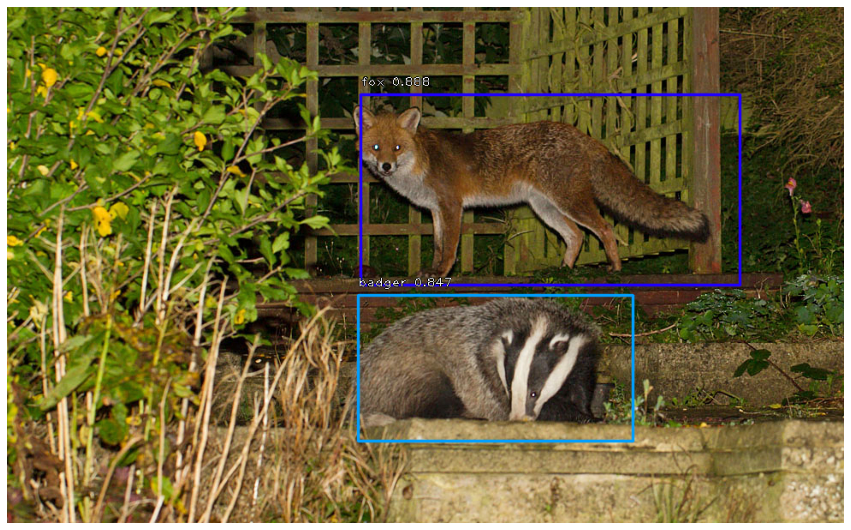

In [ ]:
image = read_image_bgr(test_image_full_path)

draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

image = preprocess_image(image)
image, scale = resize_image(image)

boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

boxes /= scale

for box, score, label in zip(boxes[0], scores[0], labels[0]):
    if score < CONFIDENCE:
        break
        
    color = label_color(label)
    
    b = box.astype(int)
    draw_box(draw, b, color=color)
    
    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(draw, b, caption)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.savefig('prediction.png')
plt.show()

In [ ]:
def display_output(imagePath):
    src = cv2.imread(imagePath,1)
    output = cv2.imread("prediction.png")

    plt.figure(figsize=[20,8])
    plt.subplot(121)
    plt.imshow(src[:,:,::-1])
    plt.title("Original Image")
    plt.subplot(122)
    plt.imshow(output[:,:,::-1])
    plt.title("Prediction")
    plt.show()

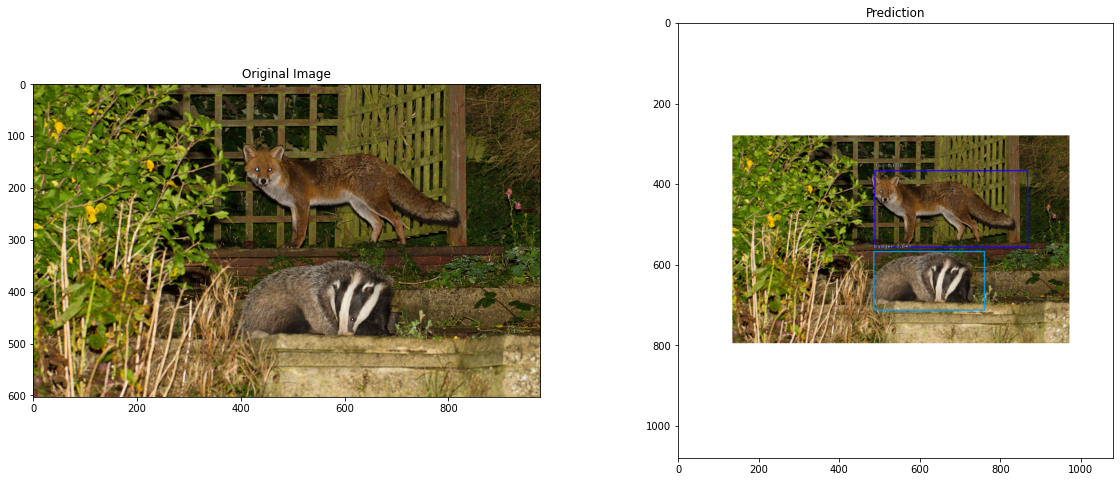

In [ ]:
display_output(test_image_full_path)